In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# Importo librerias de Scikit Learn
Puntualmente nos interesa importar el modelo de Regresion Lineal, la medida de error cuadratico medio, y el divisor de datos entre train y test.

In [75]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.model_selection import GridSearchCV

# Importo dataset de Airbnb 
Desde Airbnb obtenemos el siguiente dataset para entrenar nuestros modelos de regresion http://insideairbnb.com/get-the-data.html (dataset "listings.csv" de London). 

Objetivo: Vamos a querer predecir el precio dadas ciertas features.

In [3]:
pwd

'C:\\Users\\avelazquez\\Documents\\ClusterAI\\clase_04-master'

In [6]:
# importo el dataset de Airbnb London, lo guardamos en el dataframe "london".
london = pd.read_csv(r'clusterai_clase04_regresion_dataset_airbnb_london.csv', delimiter=',', parse_dates = True)

In [7]:
# observo la cantidad de renglones y columnas del dataset importado
np.shape(london)

(75213, 16)

In [8]:
# exploro las columnas que tiene el dataframe importado
london.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [10]:
#visualizo los primeros 3 renglones de mi dataset
london.head(3)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,9554,"Cozy, 3 minutes to Piccadilly Line",31655,Guy,NaN,Haringey,51.587767,-0.105666,Private room,35,1,131,2018-08-03,1.71,4,262
1,11076,The Sanctuary,40471,Rosa,NaN,Ealing,51.515645,-0.314508,Private room,70,2,2,2016-11-23,0.07,6,62
2,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.568017,-0.111208,Private room,45,1,14,2018-06-17,0.14,2,364


In [11]:
# cuento cuantos NaNs tengo por columna
london.isnull().sum()

id                                    0
name                                 31
host_id                               0
host_name                            13
neighbourhood_group               75213
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       20353
reviews_per_month                 20357
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [13]:
# elimino las rows que tienen NaNs en la columna "reviews_per_month" , que otras opciones existen?
london = london.dropna(subset = ["reviews_per_month"])

In [14]:
# reviso como queda mi dataframe luego de eliminar los renglones con NaNs en review per month
london.shape

(54856, 16)

## Visualización rápida de las features de interes con Pairplot (Seaborn)

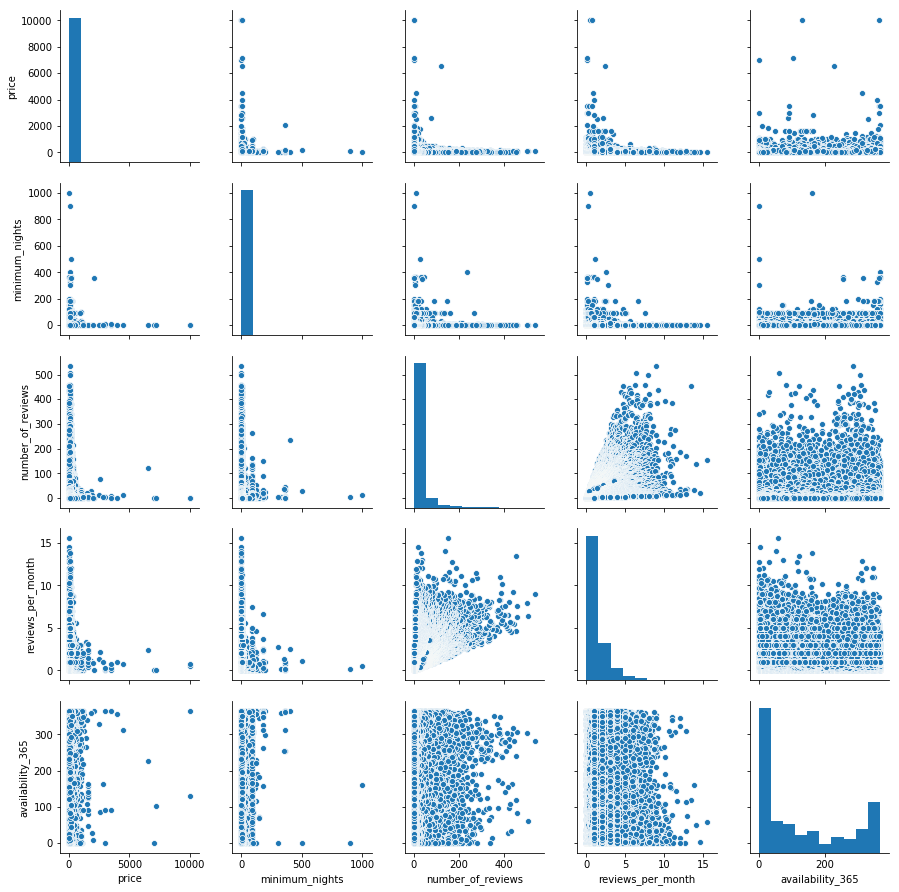

In [15]:
sns.pairplot(london[["price", "minimum_nights", "number_of_reviews", "reviews_per_month", "availability_365"]])
plt.show()

## Elimino con .drop las columnas que no son de interes

In [36]:
london = london.drop(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'last_review', 'latitude', 'longitude'], axis=1)
#Que features que eliminamos podrian llegar a ser utiles?

Link util -->
https://medium.com/@khadijamahanga/using-latitude-and-longitude-data-in-my-machine-learning-problem-541e2651e08c

In [37]:
london.head(3)

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Haringey,Private room,35,1,131,1.71,4,262
1,Ealing,Private room,70,2,2,0.07,6,62
2,Islington,Private room,45,1,14,0.14,2,364


## Reviso si los valores máximos de cada feature se condicen con el contexto

Con que objetivo queremos ver esta informacion?

In [38]:
np.max(london)

neighbourhood                     Westminster
room_type                         Shared room
price                                   10000
minimum_nights                           1000
number_of_reviews                         536
reviews_per_month                       15.56
calculated_host_listings_count           1034
availability_365                          365
dtype: object

## Obtengo los percentiles 97 de price y Minimum nights para filtrar outliers de estas features

In [39]:
price_q97 = london.price.quantile(0.975)
print("el cuantil 0.97 de la feature 'price' es = " + str(price_q97))

el cuantil 0.97 de la feature 'price' es = 300.0


In [40]:
min_nights_q97 = london.minimum_nights.quantile(0.975)
print("el cuantil 0.97 de la feature 'minimum_nights' es = " + str(min_nights_q97))

el cuantil 0.97 de la feature 'minimum_nights' es = 14.0


## Outlier Filtering: Filtro mi dataset por los percentiles calculados en el paso anterior bajo las features correspondientes

In [41]:
# aca filtro y conservo los valores que cumplen las dos condiciones al mismo tiempo
london_filt = london.loc[(london.price < price_q97) & (london.minimum_nights < min_nights_q97)]

In [42]:
london_filt.shape

(51827, 8)

In [43]:
london_filt.head(3)

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Haringey,Private room,35,1,131,1.71,4,262
1,Ealing,Private room,70,2,2,0.07,6,62
2,Islington,Private room,45,1,14,0.14,2,364


## Feature Engineering: Genero variables dummies para las features categoricas (Neighbourhood y Room Type)

In [44]:
# dummies para la feature "neighbourhood"
neighs_dummie = pd.get_dummies(london_filt.neighbourhood)
neighs_dummie.head(3)

,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,Croydon,Ealing,Enfield,...,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
neighs_dummie.shape

(51827, 33)

In [46]:
# Ejemplo de dummies para la feature "room_type"
room_dummie = pd.get_dummies(london_filt.room_type)
room_dummie.head(3)

,Entire home/apt,Private room,Shared room
0,0,1,0
1,0,1,0
2,0,1,0


In [47]:
room_dummie.shape

(51827, 3)

## Agrego las nuevas variables dummies creadas al dataframe de trabajo 'london_filt'

In [48]:
london_filt = london_filt.join([neighs_dummie, room_dummie])

In [49]:
london_filt.head(3)

,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Barking and Dagenham,Barnet,...,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,Entire home/apt,Private room,Shared room
0,Haringey,Private room,35,1,131,1.71,4,262,0,0,...,0,0,0,0,0,0,0,0,1,0
1,Ealing,Private room,70,2,2,0.07,6,62,0,0,...,0,0,0,0,0,0,0,0,1,0
2,Islington,Private room,45,1,14,0.14,2,364,0,0,...,0,0,0,0,0,0,0,0,1,0


In [50]:
print("La cantidad de features nuevas agregadas a dataframe son = " + str(np.shape(neighs_dummie)[1]+np.shape(room_dummie)[1]))

La cantidad de features nuevas agregadas a dataframe son = 36


## Creamos nuestra variable dependiente (label - etiqueta) y

In [51]:
y = np.array(london_filt[["price"]])

## Creamos nuestra variable Independiente X quitando las features que no deseamos

In [52]:
x = london_filt.drop(['price', 'neighbourhood','room_type'], axis=1)

In [53]:
np.shape(x)

(51827, 41)

## Divido el dataset entre Train y Test

In [54]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.90, random_state=42)

In [57]:
xtrain.head()

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,...,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,Entire home/apt,Private room,Shared room
4109,3,10,0.61,1,321,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8703,1,2,0.05,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
62456,4,1,0.94,1,137,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7200,2,2,0.18,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
44756,1,3,0.25,1,220,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


In [58]:
xtrain.shape

(5182, 41)

In [59]:
# Step 4: auto scaling train- set (mean = 0, std = 1)
scaler = preprocessing.StandardScaler().fit(xtrain)
scaler

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [60]:
# auto scalo mis muestras de train utilizando el scaler fiteado con el xtrain
xtrain_scal = scaler.transform(xtrain)  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [61]:
# auto scalo mis muestras de test utilizando el scaler fiteado con el xtrain
xtest_scal = scaler.transform(xtest)  

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


# Creo un modelo de Regresión Lineal

In [40]:
# 1) creo un modelo generico de regresion lineal
lr = LinearRegression()

In [41]:
# 2) Ajusto el modelo de regresion lineal utilizando el set de train, tanto las features X como las samples Y
lr.fit(xtrain_scal, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [42]:
# 3) Obtengo las predicciones que realiza mi modelo con las muestras de test, sin mostrarle las labels (Ytest)
# las predicciones las guardo en el vector "ypred"
ypred = lr.predict(xtest_scal)

In [43]:
np.shape(ypred)

(46645, 1)

In [44]:
# calculo el error de mi modelo con las muestras de train = error de train
np.sqrt(mean_squared_error(ytest, ypred))

39.299615158368816

In [45]:
mean_squared_error(ytest, ypred)

1544.459751595892

In [46]:
from sklearn.metrics import mean_absolute_error

In [47]:
mean_absolute_error(ytest, ypred)

28.08541240893334

![Inner join](https://i.imgflip.com/1vgxmu.jpg)

## Armar tres modelos de regresion usando:

    -KNN Regression
    Utilizar un GridSearchCV: como base podes utilizar los siguientes parametros
    parameters_k = np.arange(20,31,5)
    parameters_knn = [{'n_neighbors': parameters_k}]
    
    https://scikit-learn.org/stable/auto_examples/neighbors/plot_regression.html?highlight=knn
    
    -SVR
    Utilizar un GridSearchCV: como base podes utilizar los siguientes parametros:
    ​parameters_svr_rbf = [{'kernel':['rbf'] , 'C': [1,100],'gamma': [0.1,0.5] }]
    
    -Random Forest regressor
    Utilizar un GridSearchCV: como base podes utilizar los siguientes parametros:
    'n_estimators': [100, 200, 300, 1000]
    
    https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.set_params

### Comparar el R2, RMSE, MAE

Competencia

Mayor R2 = { }

Menor RMSE = { }

Menor MAE = { }